# Statanalysis. GoFast app

### Data and task description:
In this project we perform analysis of users and their behaviour for a short-term scooter-renting agencey "GoFast". The company would like to know how their users look like, how their behaviour depends on subscription, as well as to check several marketing theories.  

GoFast users utilize a mobile application to travel around the city. The service can be used:
- without a subscription
  - no monthly fee;
  - cost per minute of travel — 8 rubles;
  - the cost of starting a trip is 50 rubles;
- with an Ultra subscription
  - monthly subscription fee is 199 rubles;
  - the cost of one minute of travel is 6 rubles;
  - the cost of starting a trip is free.

The basic data includes information about users, their trips, and subscriptions.

Пользователи — users_go.csv
 - user_id	уникальный идентификатор пользователя
 - name имя пользователя
 - age	возраст
 - city город
 - subscription_type тип подписки (free, ultra)
 
Поездки — rides_go.csv
 - user_id	уникальный идентификатор пользователя
 - distance	расстояние, которое пользователь проехал в текущей сессии (в метрах)
 - duration	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
 - date	дата совершения поездки
 
Подписки — subscriptions_go.csv
 - subscription_type	тип подписки
 - minute_price	стоимость одной минуты поездки по данной подписке
 - start_ride_price	стоимость начала поездки
 - subscription_fee	стоимость ежемесячного платежа


In [1]:
#загружаем необходимые библиотеки
import pandas as pd
from scipy import stats as st
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
import numpy as np
from scipy.stats import binom

#### Загрузка данных

In [2]:
#Загрузим датафреймы
try:
    df_users = pd.read_csv('/Users/darianechaeva/yandex_data_analyst/users_go.csv')
    df_rides = pd.read_csv('/Users/darianechaeva/yandex_data_analyst/rides_go.csv', parse_dates=['date'], dayfirst=True)
    df_subscriptions = pd.read_csv('/Users/darianechaeva/yandex_data_analyst/subscriptions_go.csv')
except:
    df_users = pd.read_csv('/datasets/users_go.csv')
    df_rides = pd.read_csv('/datasets/rides_go.csv', parse_dates=['date'], dayfirst=True)
    df_subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
    
#Изучим общую информацию о датафреймах    
print(df_users.info())
display(df_users.head(10))


print(df_rides.info())
display(df_rides.head(10))


print(df_subscriptions.info())
display(df_subscriptions)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
None


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB
None


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes
None


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


- В представленных датафреймах нет пропусков
- Все столбцы имеют корректный тип данных

#### Предобработка данных

In [3]:
#изменение формата на datetime в столбце data
df_rides['month'] = df_rides['date'].dt.month
print(df_rides.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB
None


In [4]:
print('Датафрейм содержит информацию за', df_rides['date'].max() - df_rides['date'].min(), 'с', df_rides['date'].min(),\
'по', df_rides['date'].max())

Датафрейм содержит информацию за 363 days 00:00:00 с 2021-01-01 00:00:00 по 2021-12-30 00:00:00


In [5]:
#посмотрим, есть ли явные дубликаты
print('Дубликаты в df_users:', df_users.duplicated().sum())
print('Дубликаты df_rides:', df_rides.duplicated().sum())

#удалим явные дубликаты
df_users = df_users.drop_duplicates(keep='first')
print('Число дубликатов после обработки в df_users:', df_users.duplicated().sum() != 0)

Дубликаты в df_users: 31
Дубликаты df_rides: 0
Число дубликатов после обработки в df_users: False


В предобработке был добавлен новый столбец 'month', а также проверены датафреймы df_users и df_rides на наличие явных дубликатов. 31 строка из датафрейма df_users была удалена (осталось 98%исходных данных)

#### Исследовательский анализ данных

Опишем и визуализируем общую информацию о пользователях и поездках

##### Частота встречаемости городов

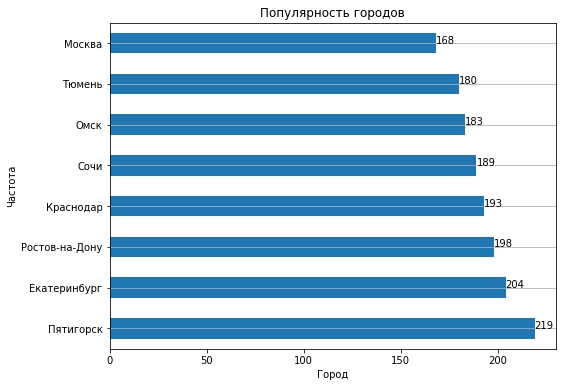

''

In [6]:
#частота встречаемости городов
df_users['city'].value_counts().plot(kind='barh', grid=True, style='o-', figsize=(8, 6))
plt.title('Популярность городов')
plt.xlabel('Город', fontsize=10)
plt.ylabel('Частота') 
plt.grid(axis='x')

# Добавим значения столбцов на график
for index, value in enumerate(df_users['city'].value_counts()):
    plt.text(value, index, str(value))

plt.show()
;

В датасете с информацией о пользователях сервиса представлено 8 разных городов. Больше всего записей в Пятигорске, а меньше всего в Москве.

##### Соотношение пользователей с подпиской и без

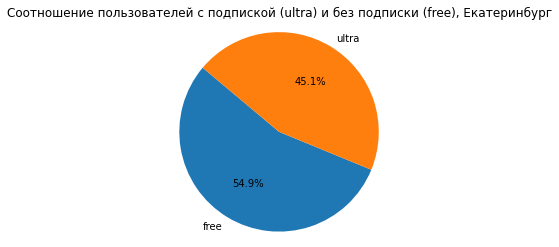

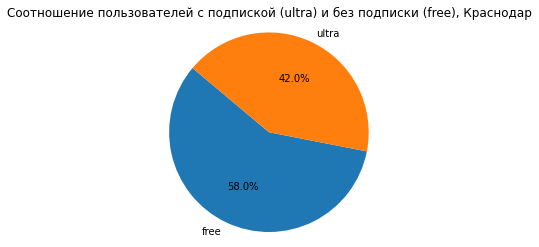

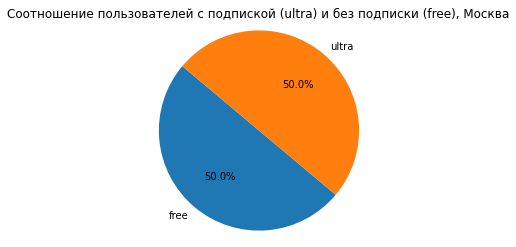

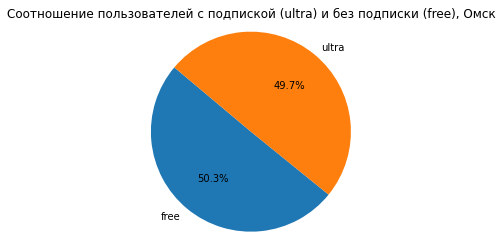

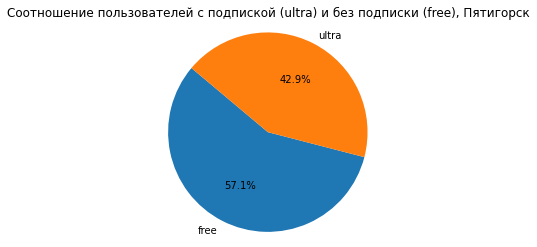

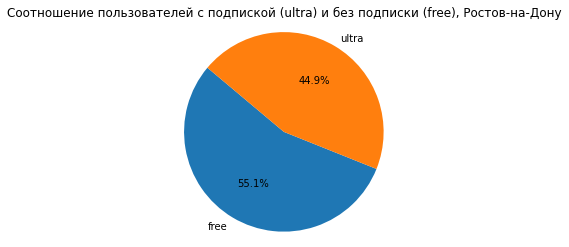

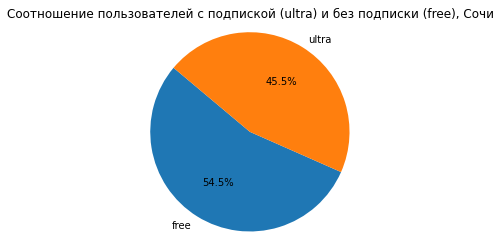

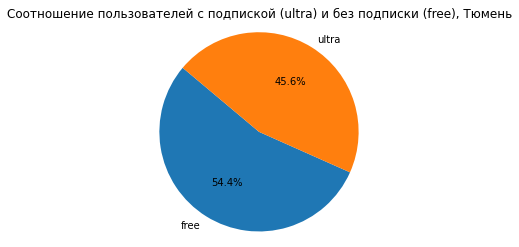

In [7]:
#соотношение пользователей с подпиской и без подписки
cities_pivot = df_users.pivot_table(index=['city'], columns='subscription_type', values='user_id', aggfunc='count')

cities = cities_pivot.index

# Построим графики для всех городов
for city in cities:
    city_data = cities_pivot.loc[city]
    labels = city_data.index
    values = city_data.values
    
    plt.figure(figsize=(4, 4)) 
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(f'Соотношение пользователей с подпиской (ultra) и без подписки (free), {city}')
    plt.axis('equal') 
    plt.show()


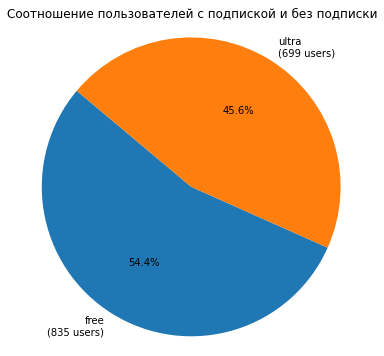

In [8]:
#Суммарное число пользователей с подпиской ultra и free
labels = cities_pivot.sum().index
values = cities_pivot.sum().values

formatted_labels = [f'{label}\n({value} users)' for label, value in zip(labels, values)] #строка, чтобы помимо % были значения пользователей

plt.figure(figsize=(6, 6))  
plt.pie(values, labels=formatted_labels, autopct='%1.1f%%', startangle=140)
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.axis('equal')  
plt.show()

Во всех городах, кроме Москвы, число пользователей без подписки превышает число пользователей с подпиской. Сумма пользователей по типу подписки тоже указывает, что первая группа (без подписки) более многочисленная

##### Возраст пользователей

In [9]:
df_users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

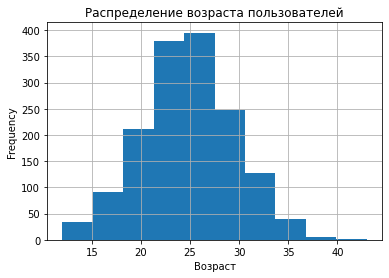

In [10]:
#изучим возраст пользователей
df_users['age'].plot(title='Распределение возраста пользователей', grid=True, kind='hist', bins=10)
plt.xlabel('Возраст')
plt.show()

Наибольшей популярностью сервис пользуется у возрастной группы 22-28 лет, максимум приходится на 25 лет.

##### Расстояние, которое пользователь преодолевает за одну поездку

In [11]:
df_rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

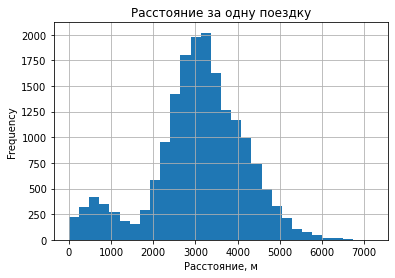

In [12]:
#расстояние, которое пользователь преодолел за одну поездку;
#df_rides.sample(10)
df_rides['distance'].plot(title='Расстояние за одну поездку', grid=True, kind='hist', bins=30)
plt.xlabel('Расстояние, м')
plt.show()

Гистограмма расстояния, которое пользователи преодолевают за одну поездку, имеет два максимума - около 600 м и 3100 м.

##### Продолжительность поездок

In [13]:
#продолжительность поездок.
df_rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

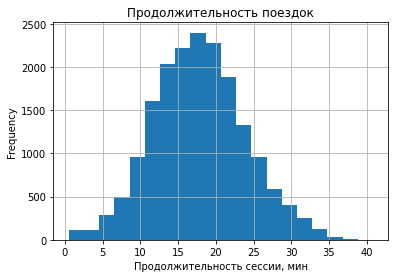

In [14]:
df_rides['duration'].plot(title='Продолжительность поездок', grid=True, kind='hist', bins=20)
plt.xlabel('Продолжительность сессии, мин')
plt.show()

Чаще всего продолжительность сессии составляет примерно 17 мин. Минимальное время сессии зафиксировано на 0,5 минутах, а максимальное - почти 41 минута.

Вывод 2: Чаще всего сессии длятся 13,6 - 21,7 мин, есть значения, выходящие за пределы 1,5 межквартильных размахов. Если принимать за скорость самоката 20 км/ч, то за сессию в 18 мин с равномерной скоростью можно проехать максимально 6 км. Гистограмма расстояний за одну поездку демонстрирует, что такое расстояние пользователи сервиса преодолевают редко. Принимая во внимание возможные остановки на светофорах и прочих препятствиях в городской среде можно считать, что данные реалистичны и пользователи действительно за 18 минут сессии преодолевают 3-4 км.

#### Объединение данных

Объединим данные о пользователях, поездках и подписках в один датафрейм. 

In [15]:
df_users_rides = df_users.merge(df_rides, on='user_id') 
df = df_users_rides.merge(df_subscriptions, on='subscription_type')
display(df.sample(10))

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6301,675,Макар,27,Краснодар,ultra,4236.522083,21.554151,2021-08-20,8,6,0,199
11679,1077,Наташа,22,Ростов-на-Дону,free,3856.267528,16.568803,2021-08-15,8,8,50,0
1179,127,Павел,25,Пятигорск,ultra,3795.931451,22.387794,2021-02-08,2,6,0,199
12074,1107,Инна,22,Краснодар,free,4148.525257,11.583156,2021-08-30,8,8,50,0
15032,1318,Мадина,28,Москва,free,2787.678472,17.194841,2021-05-18,5,8,50,0
8892,879,Анатолий,23,Екатеринбург,free,2768.965843,24.383622,2021-02-19,2,8,50,0
15106,1324,Давид,21,Ростов-на-Дону,free,2226.323790,11.565809,2021-01-26,1,8,50,0
14002,1245,Регина,27,Пятигорск,free,2479.305397,17.829385,2021-09-09,9,8,50,0
17946,1527,Захар,24,Омск,free,2433.511140,17.273697,2021-07-19,7,8,50,0
9439,918,Владимир,27,Екатеринбург,free,38.711151,11.165905,2021-06-08,6,8,50,0


In [16]:
df_users_rides.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 1.4+ MB


После объединения нескольких датафреймов df_rides (18068 строк без пропусков), df_users (1565 строк без пропусков), df_subscriptions (2 строки без пропусков), получили новый датафрейм df_users_rides, содержащий 18068 строк (столько же, сколько в df_rides, к которому мы присоединяли все другие данные), пропусков в данных после объединения не появилось, что говорит, что объединение прошло корректно.

In [17]:
#разделим на датафрейм для пользователей без подписки
df_free = df[df['subscription_type'] == 'free']
display(df_free.sample(10))

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
11564,1069,Степан,20,Сочи,free,3010.086231,12.600246,2021-05-13,5,8,50,0
11649,1075,Ника,33,Тюмень,free,3447.982057,19.169348,2021-09-11,9,8,50,0
8725,867,Леонид,24,Ростов-на-Дону,free,3011.618885,18.899779,2021-04-11,4,8,50,0
8518,850,Данила,32,Краснодар,free,4836.216803,18.817762,2021-02-05,2,8,50,0
16514,1423,Елена,30,Екатеринбург,free,3000.811859,18.002436,2021-12-21,12,8,50,0
17635,1505,Лидия,27,Екатеринбург,free,596.237129,13.882854,2021-08-30,8,8,50,0
9788,944,Маргарита,23,Пятигорск,free,2428.677420,18.571803,2021-04-25,4,8,50,0
11594,1071,Захар,26,Пятигорск,free,4541.969758,16.625909,2021-08-07,8,8,50,0
7647,783,Эдуард,20,Краснодар,free,5210.151429,26.023426,2021-02-06,2,8,50,0
9043,890,Кира,30,Омск,free,4418.324507,22.594086,2021-08-05,8,8,50,0


In [18]:
#разделим на датафрейм для пользователей с подпиской
df_ultra = df[df['subscription_type'] == 'ultra']
display(df_ultra.sample(10))

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
3630,390,Даниэль,18,Тюмень,ultra,3016.236509,25.064946,2021-08-11,8,6,0,199
352,37,Любовь,27,Ростов-на-Дону,ultra,3160.539386,16.772584,2021-08-31,8,6,0,199
5540,590,Дмитрий,28,Сочи,ultra,2815.133589,15.935766,2021-06-15,6,6,0,199
5115,550,Инна,28,Москва,ultra,4002.599863,15.577000,2021-07-05,7,6,0,199
5297,569,Роберт,32,Екатеринбург,ultra,3561.693689,21.685081,2021-11-03,11,6,0,199
4147,448,Мария,22,Москва,ultra,687.119678,15.944799,2021-06-04,6,6,0,199
2913,312,Всеволод,24,Ростов-на-Дону,ultra,3497.493968,19.772209,2021-04-26,4,6,0,199
1666,178,Игорь,26,Екатеринбург,ultra,3165.331948,24.826660,2021-12-16,12,6,0,199
2801,299,Агата,19,Омск,ultra,2920.153617,28.520922,2021-05-30,5,6,0,199
1496,162,Тамара,24,Москва,ultra,3202.499023,19.734088,2021-01-03,1,6,0,199


In [19]:
if df_users_rides.shape[0] == (df_ultra.shape[0] + df_free.shape[0]):
    print('Cовокупный размер датафреймов совпадает с количеством строк в исходной таблице')
else:
    print('Перепроверь сортированный датафрейм')

Cовокупный размер датафреймов совпадает с количеством строк в исходной таблице


Ниже представлены гистограммы для расстояний, которое преодолевают за одну поездку пользователи с подпиской и пользователи без нее

In [20]:
print(df_free['distance'].describe()) 
print('\n')
print(df_ultra['distance'].describe())

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64


count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64


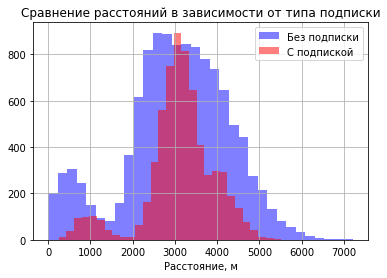

In [21]:
# Построим гистограммы в одних осях
fig, ax = plt.subplots()

ax.hist(df_free['distance'], bins=32, color='blue', alpha=0.5, label='Без подписки')


ax.hist(df_ultra['distance'], bins=30, color='red', alpha=0.5, label='С подпиской')

ax.grid(True)


ax.set_title('Сравнение расстояний в зависимости от типа подписки')
ax.set_xlabel('Расстояние, м')
ax.legend()


plt.show()

Обе гистограммы выше имеют два максимума. Для пользователей без подписки первый максимум находится на 600 м, а второй 3100 м. Для пользователей с подпиской первый максимум отличается и составляет 1000 м, а второй близок к пользователям без подписки - 3150 м.

In [22]:
print(df_free['duration'].describe())
print('\n')
print(df_ultra['duration'].describe())

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64


count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64


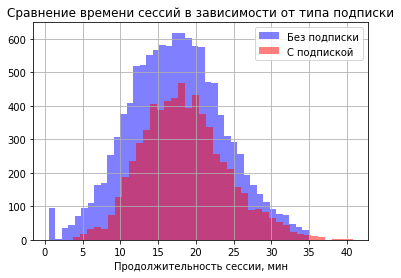

In [23]:
# Построим гистограммы в одних осях
fig, ax = plt.subplots()

ax.hist(df_free['duration'], bins=40, color='blue', alpha=0.5, label='Без подписки')


ax.hist(df_ultra['duration'], bins=40, color='red', alpha=0.5, label='С подпиской')

ax.grid(True)


ax.set_title('Сравнение времени сессий в зависимости от типа подписки')
ax.set_xlabel('Продолжительность сессии, мин')
ax.legend()


plt.show()

Чаще всего сессия у пользователей без подписки длится 17,3 минуты, у пользователей с подпиской немногим дольше - 18,2 минуты. Максимальное значение сессии у пользователей с подпиской на 5 минут дольше - 35 минут против 40.

#### Подсчёт выручки

In [24]:
#Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости 
#округлена до следующего целого числа: например, значения 25.3, 25.5 и 26.0 были преобразованы к 26.
df['duration'] = np.ceil(df['duration']) 
df.head(10)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,17.0,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,15.0,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,24.0,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,16.0,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,16.0,2021-11-22,11,6,0,199


 Создадим датафрейм с агрегированными данными о поездках на основе датафрейма df. Найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [25]:
df_pivot = df.pivot_table(index=['user_id', 'month'], values=['duration', 'distance', 'subscription_type', 'minute_price',
                                         'start_ride_price', 'subscription_fee'],
                          aggfunc={'duration': sum, 'distance': sum, 'user_id': 'count',
                                 'subscription_type': 'unique', 'minute_price': 'first',
                                 'start_ride_price': 'first','subscription_fee': 'first'
                                })
df_pivot.columns = ['distance', 'duration', 'minute_price', 'start_ride_price',
                  'subscription_fee', 'subscription_type', 'rides_completed']

display(df_pivot.head(10))

distance  duration  minute_price  start_ride_price  \
user_id month                                                           
1       1       7027.511294      42.0             6                 0   
        4        754.159807       7.0             6                 0   
        8       6723.470560      46.0             6                 0   
        10      5809.911100      32.0             6                 0   
        11      7003.499363      56.0             6                 0   
        12      6751.629942      28.0             6                 0   
2       3      10187.723006      63.0             6                 0   
        4       6164.381824      40.0             6                 0   
        6       3255.338202      14.0             6                 0   
        7       6780.722964      48.0             6                 0   

               subscription_fee subscription_type  rides_completed  
user_id month                                                       
1       1                   199           [ultra]                2  
        4                   199           [ultra]                1  
        8                   199           [ultra]                2  
        10                  199           [ultra]                2  
        11                  199           [ultra]                3  
        12                  199           [ultra]                2  
2       3                   199           [ultra]                3  
        4                   199           [ultra]                2  
        6                   199           [ultra]                1  
        7                   199           [ultra]                2

В этот же датафрейм добавим столбец с помесячной выручкой (profit), которую принёс каждый пользователь. Для этого обратимся к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. 

In [26]:
df_pivot['profit'] = df_pivot['start_ride_price'] * df_pivot['rides_completed'] + df_pivot['minute_price'] *\
    df_pivot['duration'] + df_pivot['subscription_fee']

display(df_pivot.sample(10))

,,distance,duration,minute_price,start_ride_price,subscription_fee,subscription_type,rides_completed,profit
user_id,month,,,,,,,,
1370,2,11224.657356,71.0,8,50,0,[free],3,718.0
612,4,3173.634294,19.0,6,0,199,[ultra],1,313.0
567,3,3025.923939,12.0,6,0,199,[ultra],1,271.0
813,10,2889.162204,10.0,8,50,0,[free],1,130.0
973,9,7678.181941,45.0,8,50,0,[free],2,460.0
695,11,7272.247354,33.0,6,0,199,[ultra],2,397.0
109,5,2552.298307,9.0,6,0,199,[ultra],1,253.0
1322,4,4507.181203,24.0,8,50,0,[free],2,292.0
497,12,8685.840551,49.0,6,0,199,[ultra],3,493.0


На этом этапе мы получили сводную таблицу, демонстрирующую информацию об использовании сервиса каждым пользователем  по месяцам, а также прибыли, которую получила при этом компания (столбец profit). На первый взгляд разница между прибылью от пользователей с подпиской и без нее не велика

#### Проверка гипотез

##### Сравнение времени поездок у пользователей с подпиской и без
Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим гипотезу. 
- Нулевая гипотеза в том, что средние двух генеральных совокупностей (время на поездки у пользователей с подпиской  и время у пользователей без нее) равны. 
- Альтернативная гипотеза в том, что средние времена для пользователей с подпиской больше, чем для пользователей без нее.

In [27]:
print('Среднее время для пользователей с подпиской:', df_ultra['duration'].mean())
print('Среднее время для пользователей без подписки:', df_free['duration'].mean())

alpha = 0.05 # задаем уровень статистической значимости

results_time = st.ttest_ind(df_ultra['duration'], df_free['duration'], alternative='greater')# статтест

# выведем полученное p-значение
print('p-значение:', results_time.pvalue)

if results_time.pvalue < alpha: # сравним p-значение с заданным уровнем стат. значимости
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Среднее время для пользователей с подпиской: 18.54198516280583
Среднее время для пользователей без подписки: 17.39090929866399
p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Полученные результаты говорят о том, нулевую гипотезу о равенстве времен поездок для пользователей с подпиской и без нее нужно отвергнуть. Есть основания утверждать, что средние времена для пользователей с подпиской больше, чем у пользователей без нее.

##### Среднее расстояние, которое проезжают пользователи с подпиской 
Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 
3130 метров? Проверим гипотезу.
- нулевая гипотеза, что среднее генеральной совокупности, состоящей из расстояний, которые проезжают пользователи с подпиской, равно 3130 метров
- альтернативная гипотеза в том, что среднее генеральной совокупности больше оптимального расстояния, указанного в нулевой гипотезе

In [28]:
print('Среднее расттояние, которое проезжают пользователи с подпиской:', df_ultra['distance'].mean())
optimal_value = 3130 

alpha = 0.05 # задаем уровень статистической значимости

results = st.ttest_1samp(
    df_ultra['distance'],
    optimal_value,
     alternative='greater') #статтест

# выведем полученное p-значение
print('p-значение:', results.pvalue)

if results.pvalue < alpha: # сравним p-значение с заданным уровнем стат. значимости
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Среднее расттояние, которое проезжают пользователи с подпиской: 3115.4453880370247
p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


На основании полученных результатов, отвергнуть нулевую гипотезу о близости среднего расстояния, которое проезжают пользователи с подпиской, 3130 метрам не удалось. Можно предполагать, что в среднем пользователи с подпиской проезжают не более оптимальных 3130 м.

##### Сравнение помесячной выручки для пользователей с подпиской и без нее
Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 
- Нулевая гипотеза: среднее генеральной совокупности, содержащей информацию о выручке пользователей с подпиской, равно среднему ген. совокупности, имеющей выручку для пользователей без нее 
- Альтернативная гипотеза состоит в том, что среднее значение ген. совокупности с выручкой пользователей с подпиской больше среднего ген. совокупности с выручкой для пользователей без нее

In [29]:
print('Средний доход от пользователей с подпиской:', df_pivot[df_pivot['subscription_type'] == 'ultra']['profit'].mean())
print('Средний доход от пользователей без подписки:', df_pivot[df_pivot['subscription_type'] == 'free']['profit'].mean())

alpha = 0.05 # задаем уровень статистической значимости

results_profit = st.ttest_ind(
        df_pivot[df_pivot['subscription_type'] == 'ultra']['profit'], 
        df_pivot[df_pivot['subscription_type'] == 'free']['profit'],
       # equal_var=False,
        alternative='greater')# статтест

# выведем на экран полученное p-значение
print('p-значение:', results_profit.pvalue)

if results_profit.pvalue < alpha: # сравним p-значение с заданным уровнем стат. значимости
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Средний доход от пользователей с подпиской: 362.7921906022502
Средний доход от пользователей без подписки: 328.6413651073845
p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


На основании данных нулевая гипотеза была отвергнута, значит есть основания утверждать, что пользователи с подпиской приносят компании бóльшую прибыль, чем пользователи без нее.

##### Гипотеза о числе обращений в техподдержку
Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Для проверки этой гипотезы необходимо сревнить средние двух ген совокупностей одинакового размера, до и после изменений. В таком случае необходимо использовать `st.ttest_rel(df_after, df_before)` с односторонней проверкой гипотезы и `alternative=less`
- Нулевая гипотеза заключалась бы в том, что средние числа ген.совокупностей, содержащих число обращений в техподдержку до и после обновления, равны. 
- Альтернативная - в том, что число обращений после обновления уменьшилось (среднее ген. совокупности после обновления меньше среднего числа ген. совокупности до обновления).


### Conclusions

1. The original dataframes contain no missing values, and all columns have correct data types, indicating high data quality. The dataset includes information for 363 days, from 01.01.2021 to 30.12.2021.
2. During the preprocessing stage, a new column `month` was added, and the `df_users` and `df_rides` dataframes were checked for explicit duplicates. As a result, 31 rows were removed from `df_users`, leaving 98% of the original data.
3. The dataset containing user information (`df_users`) includes data for 8 different cities. The largest number of records corresponds to Pyatigorsk, while Moscow has the fewest.
4. In all cities except Moscow, the number of users without a subscription exceeds the number of users with a subscription. The total number of users by subscription type also indicates that non-subscribed users are more numerous.
5. The service is most popular among users aged 22–28, with a peak at age 25. The mean and median values are almost identical.
6. The median rental time is approximately 18 minutes. The minimum session duration is 0.5 minutes, and the maximum is nearly 41 minutes. Most sessions last between 13.6 and 21.7 minutes, with some values lying beyond 1.5 interquartile ranges.
7. Histograms of the distance traveled by users with and without a subscription show two peaks. For users without a subscription, the first peak is at 600 meters and the second at 3,100 meters. For subscribed users, the first peak differs and is at 1,000 meters, while the second peak is similar to non-subscribed users at around 3,150 meters.
8. Most often, sessions for users without a subscription last 17.3 minutes, while sessions for subscribed users are slightly longer at 18.2 minutes. The maximum session duration for subscribed users is 5 minutes longer: 40 minutes versus 35 minutes.
9. During the analysis, a pivot table `df_pivot` was created, showing monthly service usage by each user as well as the profit generated for the company (the `profit` column).

**Hypothesis Testing**

1. The results obtained in section 6.1 indicate that the null hypothesis of equal trip durations for users with and without a subscription should be rejected. There is evidence that the average trip duration for subscribed users is longer than for non-subscribed users.

2. Based on the results from section 6.2, the null hypothesis that the average distance traveled by subscribed users is close to 3,130 meters could not be rejected. It can be assumed that, on average, subscribed users do not exceed the optimal distance of 3,130 meters.

3. Based on the results from section 6.3, the null hypothesis was rejected, indicating that subscribed users generate higher profit for the company than non-subscribed users.

**Thus, based on the study results, it can be concluded that subscribed users are more beneficial for the GoFast service, as they are more likely to generate higher profit, do not exceed the optimal travel distance of 3,130 meters, and use the service for longer periods of time.**


#### Distributions

7.1 Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 
100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 
10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.


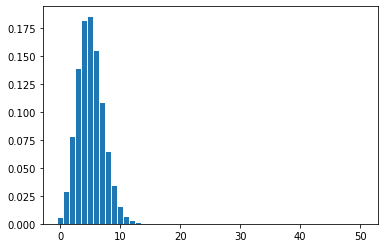

In [30]:
from matplotlib import pyplot as plt
from scipy.stats import binom

p = 0.1 # вероятность продления подписки
n = 50 # сколько промокодов нужно разослать

distr = [] # создаем список distr, в котором будем хранить значения распределения

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value) #построем биномиальное распределение вероятностей
    
plt.bar(range(0, n + 1), distr) #построем гистограмму распределения вероятностей
plt.show()



In [31]:
n = 1000
while 1 - binom.cdf(99, n, 0.1) < 0.95:
    n+=1
print('Минимальное количество промокодов, которое нужно разослать,\
    чтобы вероятность выполнить план была', 1 - binom.cdf(99, n, 0.1), \
      'достигается при', n, 'разосланных промокодов')

Минимальное количество промокодов, которое нужно разослать,    чтобы вероятность выполнить план была 0.9502390990500975 достигается при 1161 разосланных промокодов


7.2 Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 
40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

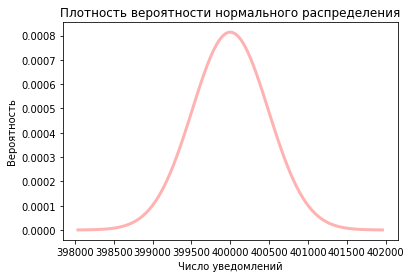

In [32]:
#строим график

from math import sqrt
import matplotlib.pyplot as plt
from scipy.stats import binom, norm
 
# зададим функцию, которая выдаёт <num> чисел,
# равномерно распределённых от <start> до <stop>
# (понадобится для визуализации нормального распределения)
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result
 
# задаём параметры биномиального распределения
n = 1000000
p = 0.4

# границы промежутка, в котором будем строить аппроксимацию -
# от n*p минус 4 ст.отклонения бином.распределения
# до n*p плюс 4 ст.отклонения бином.распределения
# (там, где вероятности значений почти не равны нулю)
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))

# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))
 
# рисуем график нормального распределения:
# получим список из 100 чисел от left до right
x = linspace(left, right, 100)
# используем красную линию ширины 3 и прозрачности 0.3
plt.plot(x, norm.pdf(x, mu, sigma), 'r-', lw=3, alpha=0.3)
plt.title('Плотность вероятности нормального распределения')
plt.xlabel('Число уведомлений')
plt.ylabel('Вероятность')
plt.show()


In [33]:
#ищем ответ на поставленный вопрос об открытых уведомлениях
# задаём параметры биномиального распределения
n = 1000000
p = 0.4

# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение
distr = st.norm(mu, sigma) 

# считаем вероятность хвоста слева от 399500
result = distr.cdf(399500)
print(f'Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей {result}')

Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей 0.15371708296369768
